In [1]:
#Importing all the libraries

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
%matplotlib inline 

In [2]:
#The Datasets

confirmed_df = pd.read_csv('time_series_covid_19_confirmed.csv')
deaths_df = pd.read_csv('time_series_covid_19_deaths.csv')
recoveries_df = pd.read_csv('time_series_covid_19_recovered.csv')

In [3]:
#The cases in the US 

US_confirmed_df = confirmed_df[confirmed_df['Country/Region'] == 'US']
US_deaths_df = deaths_df[deaths_df['Country/Region'] == 'US']
US_recoveries_df = recoveries_df[recoveries_df['Country/Region'] == 'US']



In [4]:
US_confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,6421,7783,13677,19100,25489,33276,43847,53740,65778,83836


In [5]:
US_deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,...,108,118,200,244,307,417,557,706,942,1209


In [6]:
US_recoveries_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,...,17,105,121,147,176,178,178,348,361,681


In [7]:
confirmed = US_confirmed_df.iloc[:, 4:-1].T
deaths = US_deaths_df.iloc[:, 4:-1].T
recoveries = US_recoveries_df.iloc[:, 4:-1].T


In [8]:
confirmed.head()

,225
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5


In [9]:
confirmed = confirmed.rename(columns={225: "confirmed_cases"})
deaths = deaths.rename(columns={225: "deaths"})
recoveries = recoveries.rename(columns={225: "recoveries"})
confirmed.index = pd.to_datetime(confirmed.index)
deaths.index = pd.to_datetime(deaths.index)
recoveries.index = pd.to_datetime(recoveries.index)

In [10]:
#Active cases in the US

print('Confirmed Cases in the US ' + str(confirmed['confirmed_cases'][-1]))
print('Deaths in the US ' + str(deaths['deaths'][-1]))
print('Patients Recovered in the US ' + str(recoveries['recoveries'][-1]))
US_active_cases = (confirmed['confirmed_cases'] - deaths['deaths'] - recoveries['recoveries'])
print('Active cases in US ' + str(US_active_cases[-1]))


Confirmed Cases in the US 65778
Deaths in the US 942
Patients Recovered in the US 361
Active cases in US 64475


In [11]:
print(confirmed.index)
print(deaths.index)
print(recoveries.index)

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

In [12]:
dates = confirmed.index
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
US_cases = confirmed['confirmed_cases'].T
US_total_deaths = deaths['deaths'].T
US_total_recovered = recoveries['recoveries'].T

In [13]:
# calculating the mortality and the recovery rates
mortality_rate = []
recovery_rate = [] 
mortality_rate.append(deaths['deaths']/confirmed['confirmed_cases'])
recovery_rate.append(recoveries['recoveries']/confirmed['confirmed_cases'])

In [14]:
#Forecasting for the next 30 days

days_in_future = 30
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-30]

In [15]:
#Converting the integers into datetime

start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))


In [16]:
confirmed_cases = np.array(confirmed['confirmed_cases']).reshape(-1, 1)

In [17]:
#Polynomial regression model to predict the number of confirmed cases

poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(days_since_1_22)
poly_X_test_confirmed = poly.fit_transform(confirmed_cases)
poly_future_forcast = poly.fit_transform(future_forcast)

In [18]:
#Fitting the model and predicting

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, confirmed_cases)
linear_pred = linear_model.predict(poly_future_forcast)

In [19]:
print(linear_model.coef_)

[[-2.27154515e+03  1.58407966e+03 -2.26203564e+02  1.18610962e+01
  -2.57802149e-01  1.97394362e-03]]


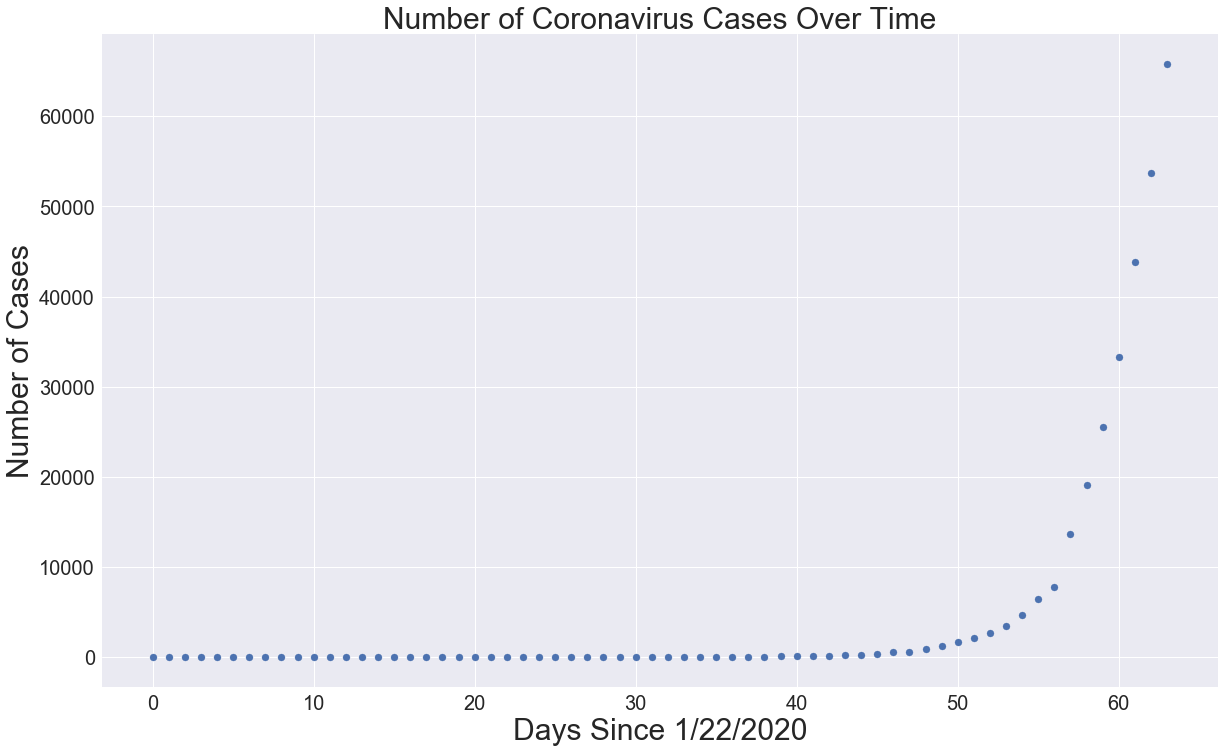

In [20]:
#Corona virus cases over time

plt.figure(figsize=(20, 12))
plt.scatter(adjusted_dates, US_cases)
plt.title('Number of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

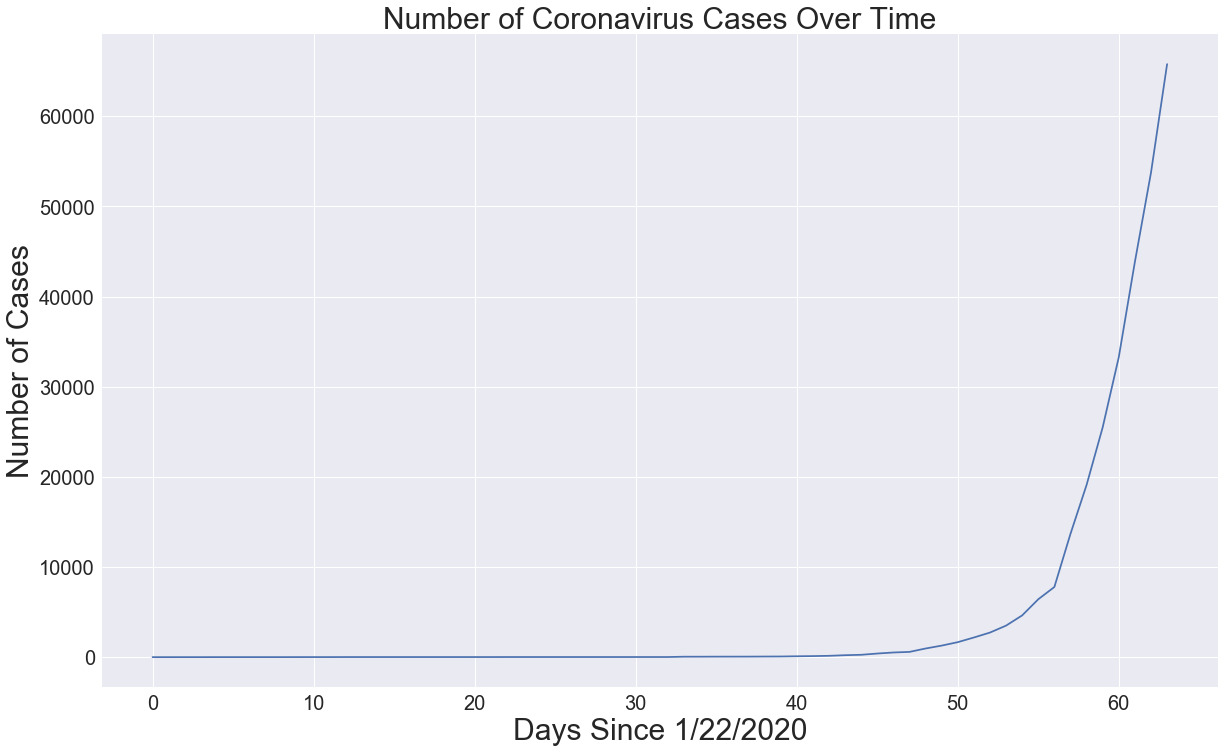

In [21]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, US_cases)
plt.title('Number of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

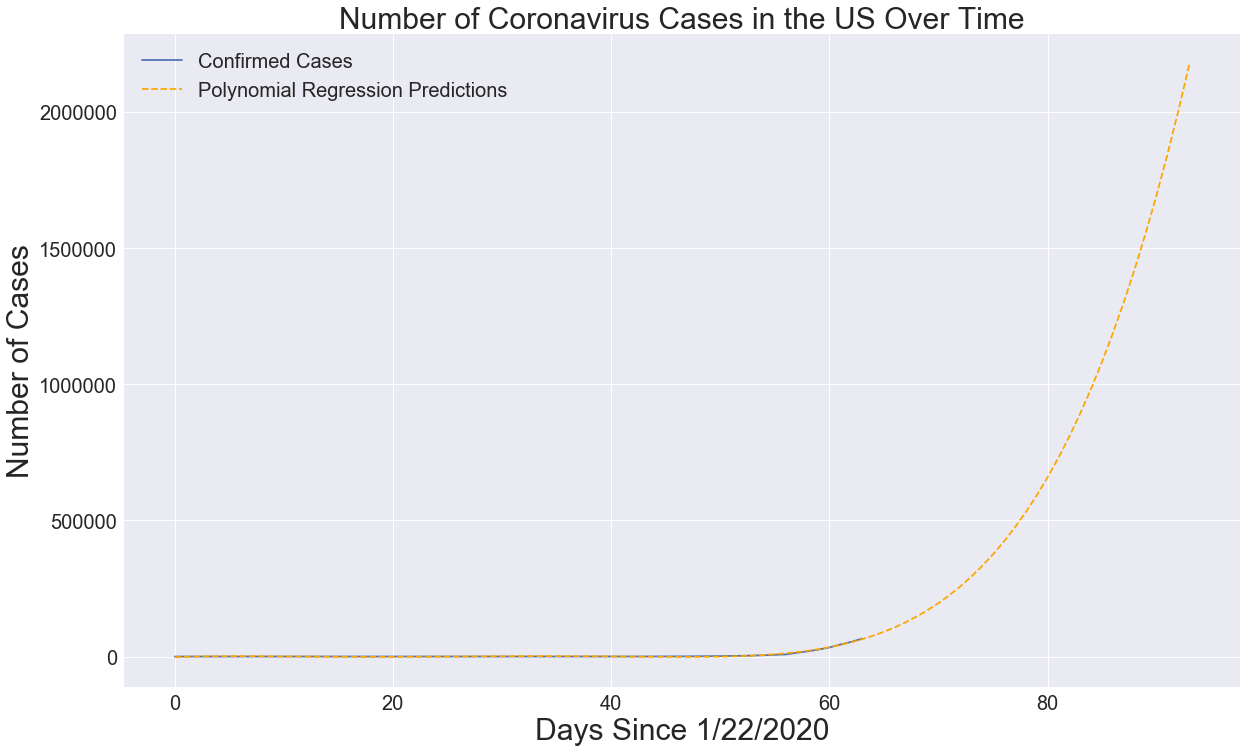

In [22]:
#Visualizing the number of confirmed cases, deaths, active cases, and the mortality rate over time, and recoveries

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, US_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Cases in the US Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('cases_in_US_next_30_day_pred.png')
plt.show()

In [23]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-30:], np.round(linear_pred[-30:])))


Polynomial regression future predictions:


{('03/26/2020', 76198.0),
 ('03/27/2020', 90756.0),
 ('03/28/2020', 107259.0),
 ('03/29/2020', 125881.0),
 ('03/30/2020', 146807.0),
 ('03/31/2020', 170229.0),
 ('04/01/2020', 196350.0),
 ('04/02/2020', 225384.0),
 ('04/03/2020', 257554.0),
 ('04/04/2020', 293094.0),
 ('04/05/2020', 332251.0),
 ('04/06/2020', 375279.0),
 ('04/07/2020', 422447.0),
 ('04/08/2020', 474033.0),
 ('04/09/2020', 530330.0),
 ('04/10/2020', 591639.0),
 ('04/11/2020', 658276.0),
 ('04/12/2020', 730569.0),
 ('04/13/2020', 808858.0),
 ('04/14/2020', 893498.0),
 ('04/15/2020', 984855.0),
 ('04/16/2020', 1083310.0),
 ('04/17/2020', 1189255.0),
 ('04/18/2020', 1303100.0),
 ('04/19/2020', 1425267.0),
 ('04/20/2020', 1556192.0),
 ('04/21/2020', 1696327.0),
 ('04/22/2020', 1846136.0),
 ('04/23/2020', 2006103.0),
 ('04/24/2020', 2176724.0)}

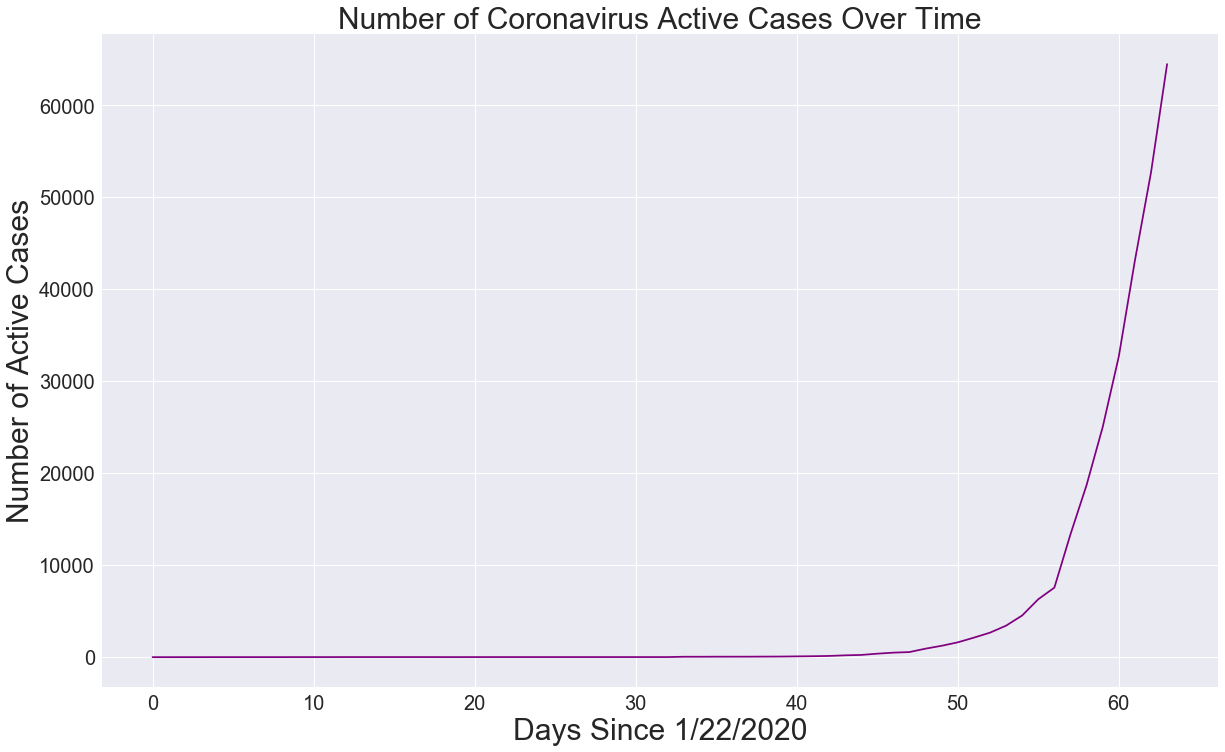

In [24]:
#Number of Active Corona virus cases over time

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, US_active_cases, color='purple')
plt.title('Number of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

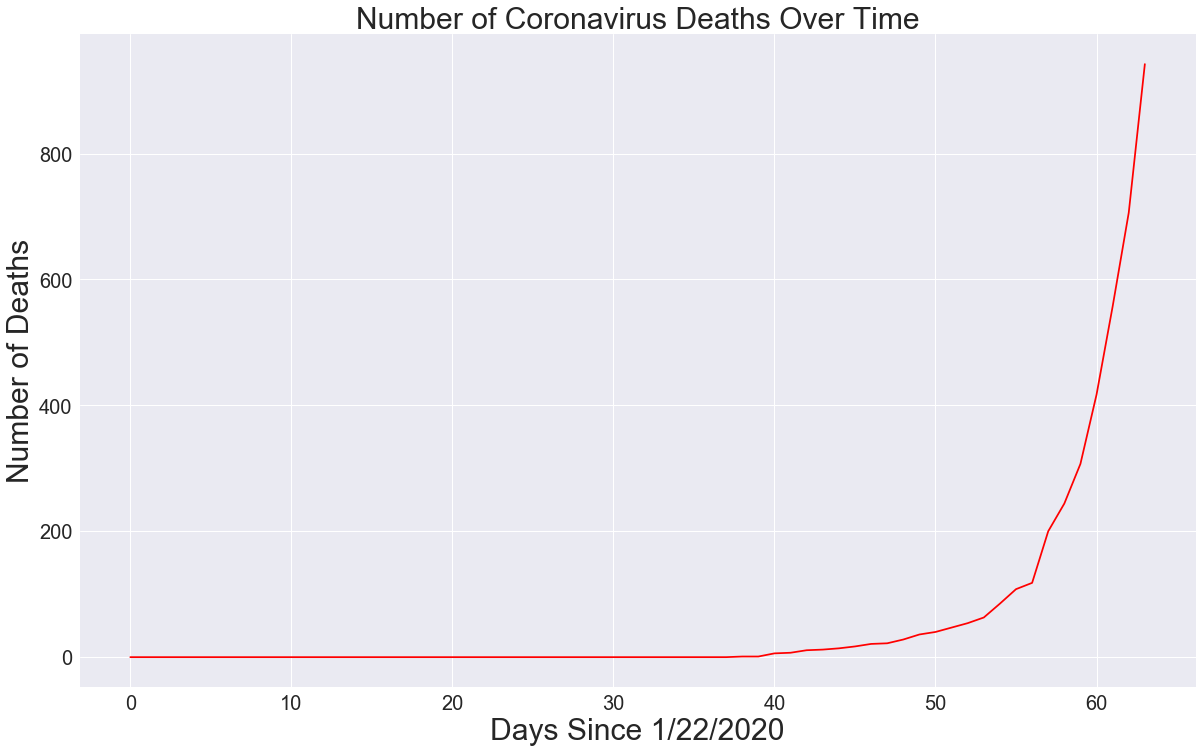

In [25]:
#Number of Corona virus deaths over time

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, US_total_deaths, color='red')
plt.title('Number of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [26]:
nan = np.isnan(mortality_rate)
mortality_rate = np.array(mortality_rate)
mortality_rate[nan] = 0.0

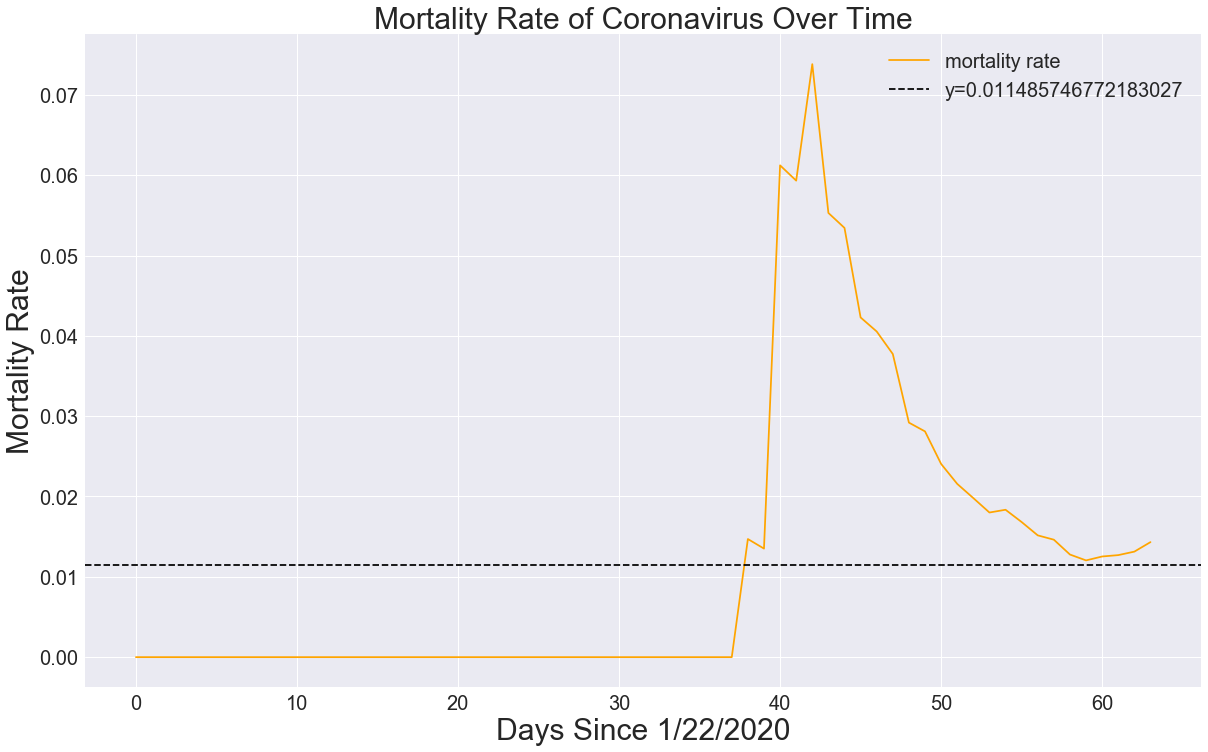

In [27]:
mean_mortality_rate = np.mean(mortality_rate.T)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate.T, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

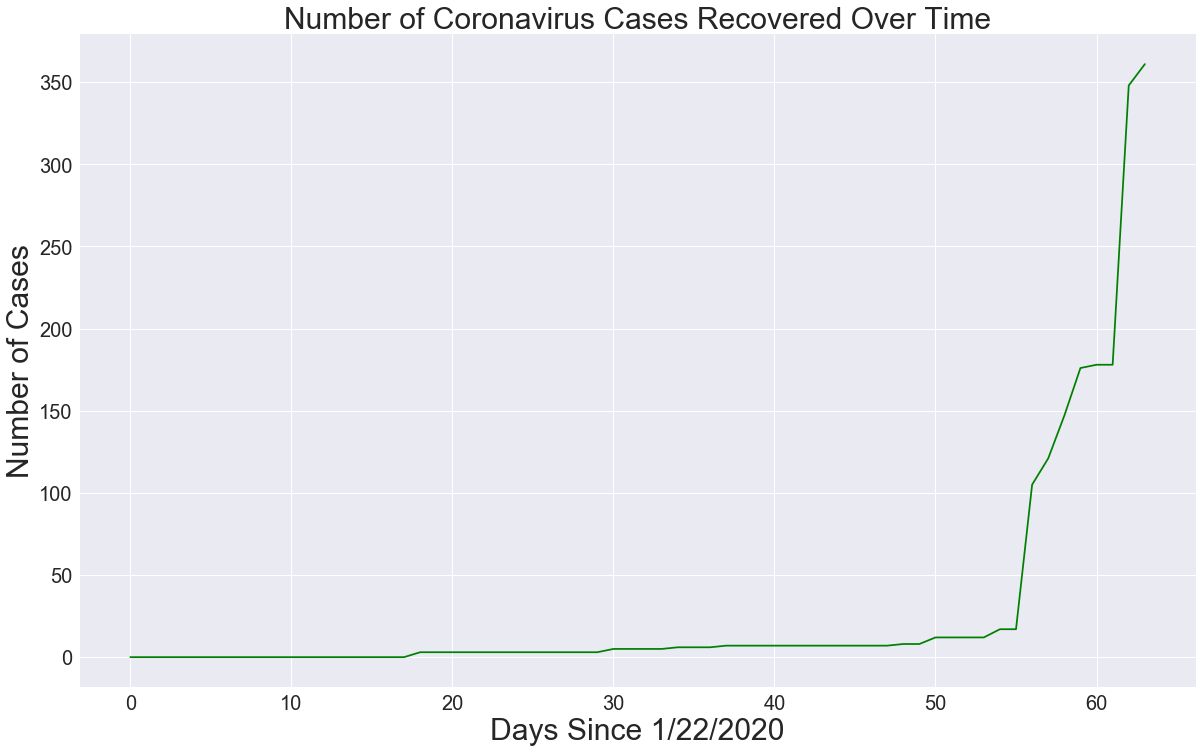

In [28]:
#Number of Patients recovered over time

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, US_total_recovered, color='green')
plt.title('Number of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [29]:
nan = np.isnan(recovery_rate)
recovery_rate = np.array(recovery_rate)
recovery_rate[nan] = 0.0

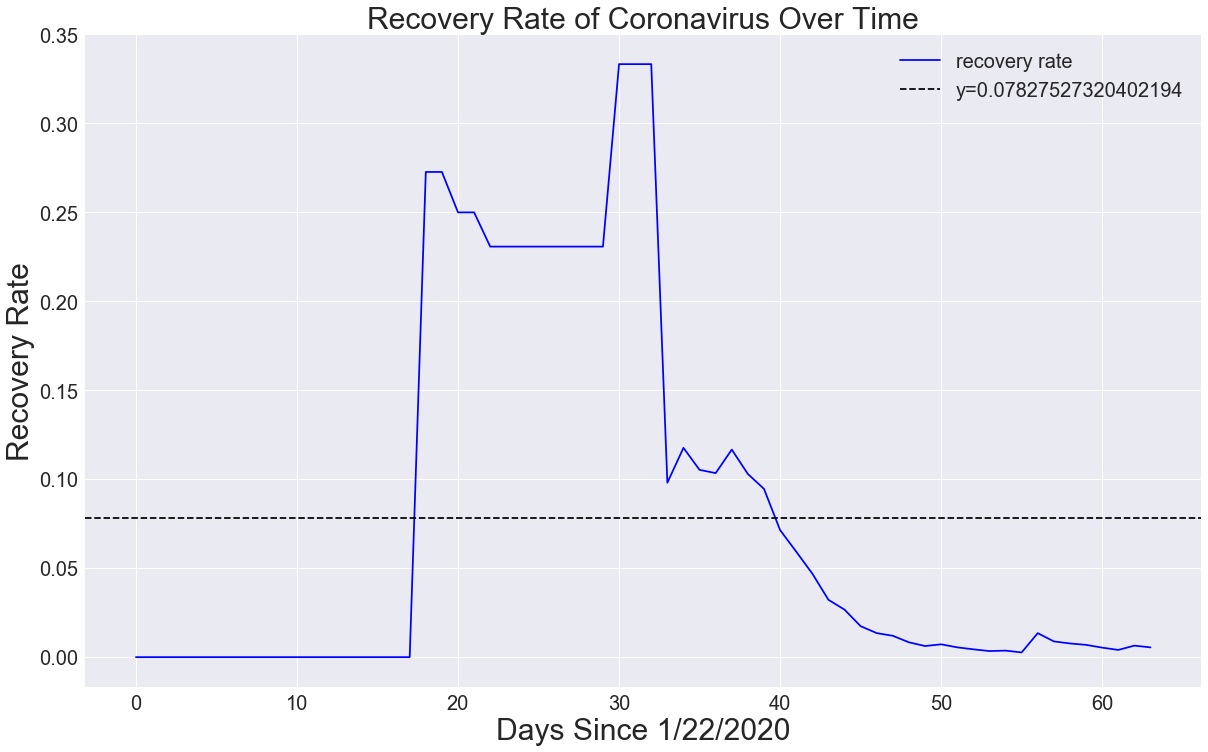

In [30]:
mean_recovery_rate = np.mean(recovery_rate.T)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, recovery_rate.T, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

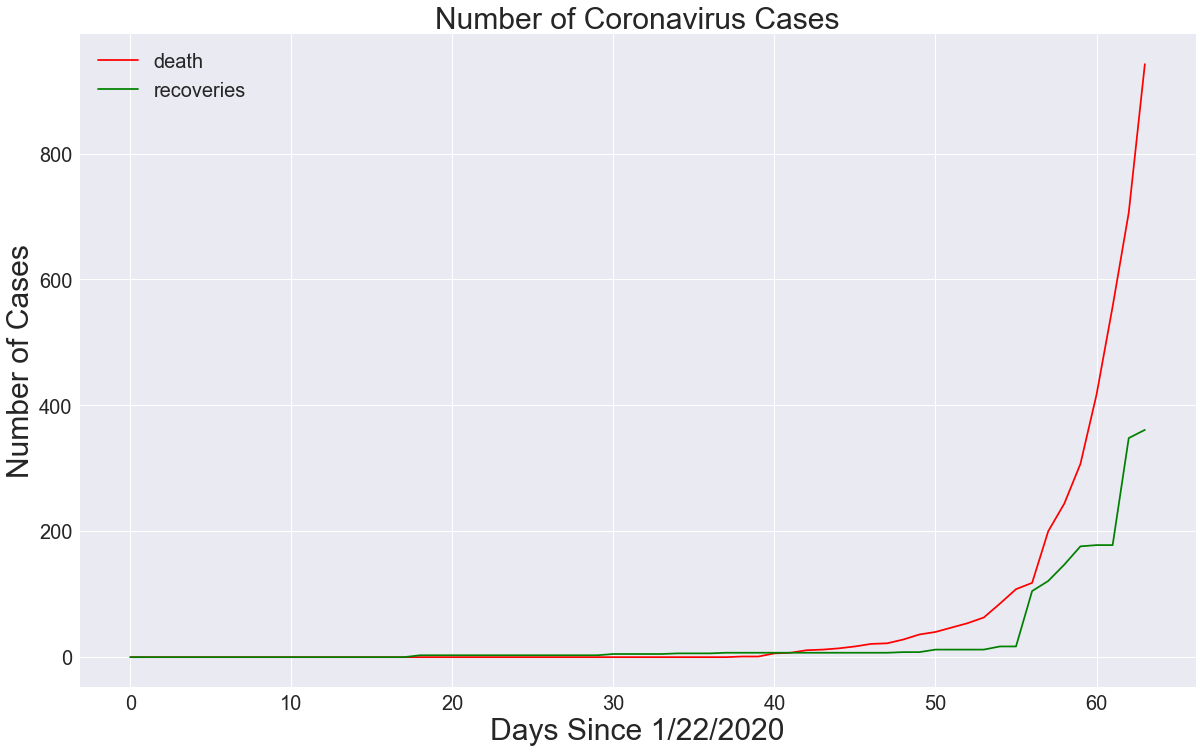

In [31]:
#Visualizing deaths against recoveries 

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, US_total_deaths, color='r')
plt.plot(adjusted_dates, US_total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('Number of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()
